# **Web Scrapping Of Ambition Box Website**


# Importing Required libraries

In [112]:
import numpy as np  # Numerical operation
import pandas as pd  # For storing and manipulating scraped data in tabular form
import re  # Regular expressions for text cleaning
import seaborn as sns   # Visualization libraries
import matplotlib.pyplot as plt 
import requests  # To send HTTP requests to the website
from bs4 import BeautifulSoup   # To parse and extract data from HTML
import warnings   # To ignore unnecessary warning messages
warnings.filterwarnings("ignore")

In [113]:
# This page contains details of multiple companies (name, rating, reviews, etc.)
url = "https://www.ambitionbox.com/list-of-companies?"

In [114]:
response=requests.get(url)
response

# Sending a request to the website
# <Response [403]> indicates "Forbidden" access.
# This means the website blocked the request, likely due to:
# 1. Missing request headers (User-Agent)
# 2. Anti-scraping protection

<Response [403]>

In [115]:
# To bypass the 403 error, we add a User-Agent header
# to mimic a real browser request.

requests_header={"content-type":"text/plain",
                "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36",
                "accept-encoding":"gzip, deflate, br, zstd"}

In [116]:
#  Sending HTTP GET request to AmbitionBox website
response=requests.get(url,headers=requests_header)

In [117]:
# Check if request was successful 
response

<Response [200]>

In [118]:
# Get the HTML content (source code) returned by the HTTP response
pagecontent=response.text

In [119]:
# Parse the HTML content using BeautifulSoup to create a searchable DOM tree
soup=BeautifulSoup(pagecontent)

In [120]:
# Find all company card sections using div tag and specific CSS class
companies = soup.find_all("div", class_="companyCardWrapper__companyPrimaryDetailsTopSection")
# Empty list to store extracted company names
company_names=[]
# Loop through each company card
for company in companies:
    # Extract text content from the div, remove extra spaces/newlines,
    # and add the cleaned company name to the list
    company_names.append(company.text.strip())
# Print first 10 company names to verify the output
print(company_names[0:10])

['TCS', 'Accenture', 'Wipro', 'Cognizant', 'Capgemini', 'HDFC Bank', 'Infosys', 'ICICI Bank', 'HCLTech', 'Tech Mahindra']


In [121]:
# Find all rating elements using div tag and rating CSS class
ratings=soup.find_all("div", class_="rating_text")
rates=[]
for i in ratings:
    rates.append(i.text.strip())
print(rates[0:10])

['3.3', '3.7', '3.6', '3.6', '3.7', '3.8', '3.5', '4.0', '3.4', '3.4']


In [122]:
# List to store number of operational locations for each company
operations_spread=[]
# Find all span elements that contain location information
for i in soup.find_all("span", class_="companyCardWrapper__interLinking"):
    text = i.text.strip()
    # Use regex to find patterns like '+3 other locations'
    # It captures the number after '+'
    loc=re.findall(r"\+(\d+)\s+other\s+locations",text) 
    # If additional locations are found
    if loc:
        # Add 1 to include the main location
        operations_spread.append(int(loc[0])+1)
    else:
        # If location info is missing, store NaN
        operations_spread.append(np.nan)

print(operations_spread[0:10])

[440, 257, 371, 231, 183, 1835, 249, 1440, 231, 332]


In [123]:
# Find all blocks that contain rating comparison information
# (Highly Rated For / Critically Rated For)

rating_blocks = soup.find_all("div", class_="companyCardWrapper__ratingComparisonWrapper")
# Find all company title elements (used for alignment)
titles_on_page = soup.find_all("a", class_="companyCardWrapper__companyName")

# Lists to store extracted ratings
h_rate=[]
c_rate=[]

# Loop through each company index
for i in range(len(titles_on_page)):

    # Check if rating block exists for this company
    if i < len(rating_blocks):
        text = rating_blocks[i].text.strip()

        # Extract text after 'Highly Rated For' and before
        # 'Critically Rated For' (if present)
        match_high = re.search(r"Highly Rated For (.*?)(?:Critically Rated For|$)", text)
        h_rate.append(match_high.group(1).strip() if match_high else np.nan)

        # Extract text after 'Critically Rated For'
        match_crit = re.search(r"Critically Rated For (.*)", text)
        c_rate.append(match_crit.group(1).strip() if match_crit else np.nan)

    # If rating block is missing for the company
    else:
        h_rate.append(np.nan)
        c_rate.append(np.nan)

print(h_rate[0:10])
print("\n")
print(c_rate[0:10])

['Job Security', nan, nan, nan, 'Work Life Balance, Job Security', 'Job Security, Skill Development / Learning', 'Job Security', 'Job Security, Promotions / Appraisal, Skill Development / Learning', nan, nan]


['Promotions / Appraisal, Salary & Benefits, Work Satisfaction', 'Promotions / Appraisal, Salary & Benefits, Work Satisfaction', 'Promotions / Appraisal, Salary & Benefits, Work Satisfaction', 'Promotions / Appraisal, Salary & Benefits, Work Satisfaction', 'Promotions / Appraisal, Salary & Benefits, Work Satisfaction', 'Promotions / Appraisal, Salary & Benefits', 'Promotions / Appraisal, Salary & Benefits, Work Satisfaction', nan, 'Promotions / Appraisal, Salary & Benefits, Work Satisfaction', 'Promotions / Appraisal, Salary & Benefits, Work Satisfaction']


In [124]:
# Find all span elements that contain company type information
typeofcomp=soup.find_all("span", class_="companyCardWrapper__interLinking")
# List to store extracted company types
types=[]

# Loop through each company type span
for i in typeofcomp:

    # Check if the text contains '|' separator
    # (AmbitionBox uses 'Type | Location | Size' format)
    if "|" in str(i):
        # Split text at '|' and take the first part as company type
        text = i.text.split("|")[0].strip()
        types.append(text)
    else:
        # If type information is missing, assign NA
        types.append("NA")

print(types[0:10])

['IT Services & Consulting', 'IT Services & Consulting', 'IT Services & Consulting', 'IT Services & Consulting', 'IT Services & Consulting', 'Banking', 'IT Services & Consulting', 'Banking', 'IT Services & Consulting', 'IT Services & Consulting']


In [125]:
locations=soup.find("span", class_="companyCardWrapper__interLinking")
locations

<span class="companyCardWrapper__interLinking">
								IT Services &amp; Consulting | Bengaluru +439 other locations
							</span>

In [126]:
# Find all span elements that contain combined company info
# (Type | Location | Size | etc.)

locations=soup.find_all("span", class_="companyCardWrapper__interLinking")
location=[]
# Loop through each span element
for i in locations:
    # Check if the text contains '|' separator
    if "|" in str(i):
        # Split by '|', take the SECOND part (location),
        # remove extra spaces, then take only the first word
        text = i.text.split("|")[1].strip().split(" ")[0]
        location.append(text)
    else:
         # If location info is missing
        location.append("NA")

print(location[0:20])

['Bengaluru', 'Bengaluru', 'Hyderabad', 'Hyderabad', 'Bengaluru', 'Mumbai', 'Bengaluru', 'Mumbai', 'Chennai', 'Hyderabad', 'Hyderabad', 'Mumbai', 'Mumbai', 'Mumbai', 'Bengaluru', 'Bengaluru', 'Noida', 'Mumbai', 'Bengaluru', 'Bengaluru']


In [127]:
counts=soup.find("span", class_="companyCardWrapper__ActionCount")
counts

<span class="companyCardWrapper__ActionCount">1.1L</span>

In [128]:
# Find all span elements that contain action counts
# (Reviews, Salaries, Interviews, Jobs, Benefits, Photos)

counts=soup.find_all("span", class_="companyCardWrapper__ActionCount")

# Lists to store extracted values
reviews=[]
reviews_1=[]
salaries=[]
interviews=[]
jobs=[]
benefits=[]
photos=[]
for i in counts:
    # Append raw text (count) to reviews list
    reviews.append(i.text)
    # From the combined list, extract values using step slicing
    # Every 6 values correspond to one company:
    # index 0 → Reviews
    # index 1 → Salaries
    # index 2 → Interviews
    # index 3 → Jobs
    # index 4 → Benefits
    # index 5 → Photos
    reviews_1.extend(reviews[0::6])
    salaries.extend(reviews[1::6])
    interviews.extend(reviews[2::6])
    jobs.extend(reviews[3::6])
    benefits.extend(reviews[4::6])
    photos.extend(reviews[5::6])
print(reviews[0:10])
print("\n")
print(reviews_1[0:10])
print("\n")
print(salaries[0:10])
print("\n") 
print(interviews[0:10])
print("\n")
print(jobs[0:10])
print("\n")
print(benefits[0:10])
print("\n")
print(photos[0:10])

['1.1L', '9.8L', '11.9k', '2.7k', '10.6k', '93', '71.7k', '6.5L', '9.2k', '42.4k']


['1.1L', '1.1L', '1.1L', '1.1L', '1.1L', '1.1L', '1.1L', '71.7k', '1.1L', '71.7k']


['9.8L', '9.8L', '9.8L', '9.8L', '9.8L', '9.8L', '9.8L', '6.5L', '9.8L', '6.5L']


['11.9k', '11.9k', '11.9k', '11.9k', '11.9k', '11.9k', '11.9k', '9.2k', '11.9k', '9.2k']


['2.7k', '2.7k', '2.7k', '2.7k', '2.7k', '2.7k', '2.7k', '42.4k', '2.7k', '42.4k']


['10.6k', '10.6k', '10.6k', '10.6k', '10.6k', '10.6k', '10.6k', '6.7k', '10.6k', '6.7k']


['93', '93', '93', '93', '93', '93', '93', '49', '93', '49']


In [129]:
import requests
from bs4 import BeautifulSoup
import re
company_names=[]
rates=[]
rate_count = []
types=[]
location=[]
reviews_1=[]
salaries = []
interviews =[]
jobs = []
benefits = []
photos = []
h_rate=[]
c_rate=[]
operations_spread=[]
us="https://www.ambitionbox.com/list-of-companies?"
for i in range(1,26):
    url=us+"page="+str(i)
    page = requests.get(url, headers=requests_header)
    soup=BeautifulSoup(page.text)
    companies = soup.find_all("div", class_="companyCardWrapper__companyPrimaryDetailsTopSection")
    for company in companies:
        company_names.append(re.findall(r"\w+",company.text))
        
    ratings=soup.find_all("div", class_="rating_text")
    for i in ratings:
        rates.append(re.findall(r"\w+\W\w+",i.text))
    
     # operations_spread
    for i in soup.find_all("span", class_="companyCardWrapper__interLinking"):
        text = i.text.strip()
        loc=re.findall(r"\+(\d+)\s+other\s+locations",text) 
        if loc:
            operations_spread.append(int(loc[0])+1)
        else:
            operations_spread.append(np.nan)

    # Highly Rated & Critically rated
    rating_blocks = soup.find_all("div", class_="companyCardWrapper__ratingComparisonWrapper")
    titles_on_page = soup.find_all("a", class_="companyCardWrapper__companyName")
    
    for i in range(len(titles_on_page)):
        if i < len(rating_blocks):
            text = rating_blocks[i].text.strip()
    
            match_high = re.search(r"Highly Rated For (.*?)(?:Critically Rated For|$)", text)
            h_rate.append(match_high.group(1).strip() if match_high else np.nan)
    
            match_crit = re.search(r"Critically Rated For (.*)", text)
            c_rate.append(match_crit.group(1).strip() if match_crit else np.nan)
        else:
            h_rate.append(np.nan)
            c_rate.append(np.nan)

    typeofcomp=soup.find_all("span", class_="companyCardWrapper__interLinking")
    for i in typeofcomp:
        if "|" in str(i):
            text = i.text.split("|")[0].strip()
            types.append(text)
        else:
            types.append("NA")
        
    locations=soup.find_all("span", class_="companyCardWrapper__interLinking")
    for i in locations:
        if "|" in str(i):
            text = i.text.split("|")[1].strip().split(" ")[0]
            location.append(text)
        else:
            location.append("NA")
    counts=soup.find_all("span", class_="companyCardWrapper__ActionCount")
    reviews=[]
    for i in counts:
        reviews.append(i.text)
    reviews_1.extend(reviews[0::6])
    salaries.extend(reviews[1::6])
    interviews.extend(reviews[2::6])
    jobs.extend(reviews[3::6])
    benefits.extend(reviews[4::6])
    photos.extend(reviews[5::6])
    print(url)

https://www.ambitionbox.com/list-of-companies?page=1
https://www.ambitionbox.com/list-of-companies?page=2
https://www.ambitionbox.com/list-of-companies?page=3
https://www.ambitionbox.com/list-of-companies?page=4
https://www.ambitionbox.com/list-of-companies?page=5
https://www.ambitionbox.com/list-of-companies?page=6
https://www.ambitionbox.com/list-of-companies?page=7
https://www.ambitionbox.com/list-of-companies?page=8
https://www.ambitionbox.com/list-of-companies?page=9
https://www.ambitionbox.com/list-of-companies?page=10
https://www.ambitionbox.com/list-of-companies?page=11
https://www.ambitionbox.com/list-of-companies?page=12
https://www.ambitionbox.com/list-of-companies?page=13
https://www.ambitionbox.com/list-of-companies?page=14
https://www.ambitionbox.com/list-of-companies?page=15
https://www.ambitionbox.com/list-of-companies?page=16
https://www.ambitionbox.com/list-of-companies?page=17
https://www.ambitionbox.com/list-of-companies?page=18
https://www.ambitionbox.com/list-of-c

In [130]:
print(len(company_names))
print(len(reviews_1))
print(len(salaries))
print(len(location))


500
500
500
500


In [131]:
d={
    "Company":company_names,
    "Rating":rates,
    "Industry":types,
    "Location":location,
    "Reviews":reviews_1,
    "Salaries":salaries,
    "Interviews":interviews,
    "Jobs":jobs,
    "Benefits":benefits,
    "Photos":photos,
    "Highly_Rated_For":h_rate,
    "Critically_Rated_For":c_rate,
    "Total_Operations_Spread":operations_spread}

In [132]:
df = pd.DataFrame(d)
df

,Company,Rating,Industry,Location,Reviews,Salaries,Interviews,Jobs,Benefits,Photos,Highly_Rated_For,Critically_Rated_For,Total_Operations_Spread
0,[TCS],[3.3],IT Services & Consulting,Bengaluru,1.1L,9.8L,11.9k,2.7k,10.6k,93,Job Security,"Promotions / Appraisal, Salary & Benefits, Wor...",440
1,[Accenture],[3.7],IT Services & Consulting,Bengaluru,71.7k,6.5L,9.2k,38.8k,6.7k,49,NaN,"Promotions / Appraisal, Salary & Benefits, Wor...",257
2,[Wipro],[3.6],IT Services & Consulting,Hyderabad,63.7k,4.8L,6.7k,7.2k,4.6k,107,NaN,"Promotions / Appraisal, Salary & Benefits, Wor...",371
3,[Cognizant],[3.6],IT Services & Consulting,Hyderabad,60.1k,6L,6.3k,650,5.5k,86,NaN,"Promotions / Appraisal, Salary & Benefits, Wor...",231
4,[Capgemini],[3.7],IT Services & Consulting,Bengaluru,51.7k,4.8L,5.5k,2.1k,3.7k,42,"Work Life Balance, Job Security","Promotions / Appraisal, Salary & Benefits, Wor...",183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,"[Honeywell, Automation]",[3.7],Industrial Automation,Pune,1.9k,11.9k,133,--,159,--,NaN,"Promotions / Appraisal, Work Satisfaction",79
496,"[Paisabazaar, com]",[3.4],Internet,Gurugram,1.9k,7k,167,46,98,25,NaN,"Job Security, Promotions / Appraisal, Company ...",36
497,[Schindler],[3.9],Industrial Machinery,Pune,1.9k,6.2k,123,64,194,3,"Skill Development / Learning, Company Culture,...",Promotions / Appraisal,89
498,"[R, R, Donnelley]",[3.6],Marketing & Advertising,Chennai,1.9k,10.1k,128,35,243,1,Job Security,"Promotions / Appraisal, Salary & Benefits",27


In [133]:
raw_df = df.copy()

# Save raw data
raw_df.to_csv("ambitionbox_raw_data.csv", index=False)

print("Raw data saved successfully.")


Raw data saved successfully.


In [134]:
df=pd.read_csv("ambitionbox_raw_data.csv")

In [135]:
df

,Company,Rating,Industry,Location,Reviews,Salaries,Interviews,Jobs,Benefits,Photos,Highly_Rated_For,Critically_Rated_For,Total_Operations_Spread
0,['TCS'],['3.3'],IT Services & Consulting,Bengaluru,1.1L,9.8L,11.9k,2.7k,10.6k,93,Job Security,"Promotions / Appraisal, Salary & Benefits, Wor...",440
1,['Accenture'],['3.7'],IT Services & Consulting,Bengaluru,71.7k,6.5L,9.2k,38.8k,6.7k,49,NaN,"Promotions / Appraisal, Salary & Benefits, Wor...",257
2,['Wipro'],['3.6'],IT Services & Consulting,Hyderabad,63.7k,4.8L,6.7k,7.2k,4.6k,107,NaN,"Promotions / Appraisal, Salary & Benefits, Wor...",371
3,['Cognizant'],['3.6'],IT Services & Consulting,Hyderabad,60.1k,6L,6.3k,650,5.5k,86,NaN,"Promotions / Appraisal, Salary & Benefits, Wor...",231
4,['Capgemini'],['3.7'],IT Services & Consulting,Bengaluru,51.7k,4.8L,5.5k,2.1k,3.7k,42,"Work Life Balance, Job Security","Promotions / Appraisal, Salary & Benefits, Wor...",183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,"['Honeywell', 'Automation']",['3.7'],Industrial Automation,Pune,1.9k,11.9k,133,--,159,--,NaN,"Promotions / Appraisal, Work Satisfaction",79
496,"['Paisabazaar', 'com']",['3.4'],Internet,Gurugram,1.9k,7k,167,46,98,25,NaN,"Job Security, Promotions / Appraisal, Company ...",36
497,['Schindler'],['3.9'],Industrial Machinery,Pune,1.9k,6.2k,123,64,194,3,"Skill Development / Learning, Company Culture,...",Promotions / Appraisal,89
498,"['R', 'R', 'Donnelley']",['3.6'],Marketing & Advertising,Chennai,1.9k,10.1k,128,35,243,1,Job Security,"Promotions / Appraisal, Salary & Benefits",27


# Initial Data Inspection 

In [136]:
# shape of Dataframe
df.shape

(500, 13)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Company                  500 non-null    object
 1   Rating                   500 non-null    object
 2   Industry                 499 non-null    object
 3   Location                 499 non-null    object
 4   Reviews                  500 non-null    object
 5   Salaries                 500 non-null    object
 6   Interviews               500 non-null    object
 7   Jobs                     500 non-null    object
 8   Benefits                 500 non-null    object
 9   Photos                   500 non-null    object
 10  Highly_Rated_For         340 non-null    object
 11  Critically_Rated_For     409 non-null    object
 12  Total_Operations_Spread  500 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 50.9+ KB


In [138]:
df.describe(include = 'all')

,Company,Rating,Industry,Location,Reviews,Salaries,Interviews,Jobs,Benefits,Photos,Highly_Rated_For,Critically_Rated_For,Total_Operations_Spread
count,500,500,499,499,500,500,500,500,500,500,340,409,500.000000
unique,499,21,55,41,107,260,334,205,344,74,59,52,NaN
top,"['Saint', 'Gobain']",['3.9'],IT Services & Consulting,Bengaluru,2.1k,6.8k,125,--,243,9,Job Security,Promotions / Appraisal,NaN
freq,2,90,71,111,35,11,7,64,6,29,36,166,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223.916000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.792877
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.500000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287.250000


- **Data Quality Check**
# Identify Null Values 

In [139]:
df.isnull().sum()

Company                      0
Rating                       0
Industry                     1
Location                     1
Reviews                      0
Salaries                     0
Interviews                   0
Jobs                         0
Benefits                     0
Photos                       0
Highly_Rated_For           160
Critically_Rated_For        91
Total_Operations_Spread      0
dtype: int64

In [140]:
# to see null value percentage
(df.isnull().sum() / len(df)) * 100


Company                     0.0
Rating                      0.0
Industry                    0.2
Location                    0.2
Reviews                     0.0
Salaries                    0.0
Interviews                  0.0
Jobs                        0.0
Benefits                    0.0
Photos                      0.0
Highly_Rated_For           32.0
Critically_Rated_For       18.2
Total_Operations_Spread     0.0
dtype: float64

# Identify Duplicate Values 

In [141]:
df.duplicated().sum()

0

# Outlier Detection

In [142]:
num_cols = df.select_dtypes(include = ["int64","float64"]).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    
    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
    
    print(f"{col} Outliers:", len(outliers))


Total_Operations_Spread Outliers: 31


# Visual of Outliers 

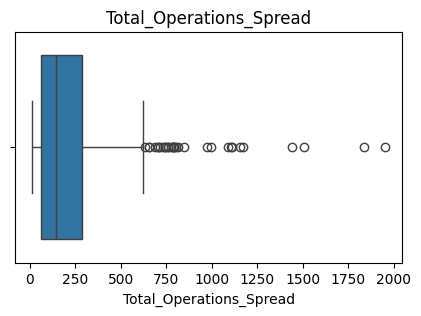

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in num_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()


# Unique Value Analysis

In [143]:
for col in df.columns:
    print(f"\nColumn: {col}")
    print("Unique Count:", df[col].nunique())
    print(df[col].unique()[:5])
    print("-"*30)


Column: Company
Unique Count: 499
["['TCS']" "['Accenture']" "['Wipro']" "['Cognizant']" "['Capgemini']"]
------------------------------

Column: Rating
Unique Count: 21
["['3.3']" "['3.7']" "['3.6']" "['3.8']" "['3.5']"]
------------------------------

Column: Industry
Unique Count: 55
['IT Services & Consulting' 'Banking' 'BPO' 'Telecom' 'Internet']
------------------------------

Column: Location
Unique Count: 41
['Bengaluru' 'Hyderabad' 'Mumbai' 'Chennai' 'Noida']
------------------------------

Column: Reviews
Unique Count: 107
['1.1L' '71.7k' '63.7k' '60.1k' '51.7k']
------------------------------

Column: Salaries
Unique Count: 260
['9.8L' '6.5L' '4.8L' '6L' '1.5L']
------------------------------

Column: Interviews
Unique Count: 334
['11.9k' '9.2k' '6.7k' '6.3k' '5.5k']
------------------------------

Column: Jobs
Unique Count: 205
['2.7k' '38.8k' '7.2k' '650' '2.1k']
------------------------------

Column: Benefits
Unique Count: 344
['10.6k' '6.7k' '4.6k' '5.5k' '3.7k']
-----

In [144]:
for col in df.columns:
    print(f"\nColumn: {col}")
    print("Unique Count:", df[col].nunique())
    print(df[col].unique())
    print("-"*30)


Column: Company
Unique Count: 499
["['TCS']" "['Accenture']" "['Wipro']" "['Cognizant']" "['Capgemini']"
 "['HDFC', 'Bank']" "['Infosys']" "['ICICI', 'Bank']" "['HCLTech']"
 "['Tech', 'Mahindra']" "['Genpact']" "['Teleperformance']" "['Jio']"
 "['Axis', 'Bank']" "['Concentrix', 'Corporation']" "['Amazon']"
 "['iEnergizer']" "['Reliance', 'Retail']" "['LTIMindtree']" "['IBM']"
 "['HDB', 'Financial', 'Services']" "['Larsen', 'Toubro', 'Limited']"
 "['Deloitte']" "['Kotak', 'Mahindra', 'Bank']"
 "['Reliance', 'Industries']" "['Vodafone', 'Idea']"
 "['Bharti', 'Airtel']" "['BYJU', 'S']" "['WNS']"
 "['IDFC', 'FIRST', 'Bank']" "['Ernst', 'Young']" "['Tata', 'Motors']"
 "['IndusInd', 'Bank']" "['AU', 'Small', 'Finance', 'Bank']"
 "['Bajaj', 'Finserv']" "['Flipkart']" "['Muthoot', 'FinCorp']" "['PwC']"
 "['Mahindra', 'Mahindra']" "['Infosys', 'BPM']" "['DXC', 'Technology']"
 "['HDFC', 'Life']" "['Bandhan', 'Bank']" "['Digitide', 'Solutions']"
 "['Mphasis']" "['Yes', 'Bank']" "['Tata', 'Steel'

# Comapny Name Cleaning ( Removing "," spaces,in between the names)

In [145]:
import ast

col = "Company"

def clean_company(x):
    try:
        # Convert string representation of list into actual list
        company_list = ast.literal_eval(x)
        
        # Join words with space (removes commas automatically)
        return " ".join(company_list)
    
    except:
        return x

df[col] = df[col].apply(clean_company)

# Optional: remove extra spaces
df[col] = df[col].str.replace(r"\s+", " ", regex=True).str.strip()


In [146]:
import ast
import re

col = "Company"

def clean_company(x):
    try:
        company_list = ast.literal_eval(x)
        name = " ".join(company_list)
    except:
        name = x

    # Fix L T → L&T
    name = re.sub(r"\bL T\b", "L&T", name)

    # Fix R R → R.R.
    name = re.sub(r"\bR R\b", "R.R.", name)

    # Fix BYJU S → BYJU'S
    name = re.sub(r"\bBYJU S\b", "BYJU'S", name)

    # Remove extra spaces
    name = re.sub(r"\s+", " ", name).strip()

    return name

df[col] = df[col].apply(clean_company)


In [147]:
import re

col = "Company"

# Create correction dictionary
corrections = {
    "Dr Reddy s": "Dr. Reddy's",
    "Domino s Pizza": "Domino's Pizza",
    "McDonald s": "McDonald's",
    "S P Global": "S&P Global",
    "Automatic Data Processing ADP": "Automatic Data Processing (ADP)",
    "Paisabazaar com": "Paisabazaar.com",
    "vivo": "Vivo",
    "Whitehat jr": "WhiteHat Jr",
    "Exl India": "EXL India",
    "24 7 ai": "24/7.ai",
    "Statestreet HCL Services": "State Street HCL Services",
    "Star Union Dai ichi Life Insurance": "Star Union Dai-ichi Life Insurance",
    "JPMorgan Chase Co": "JPMorgan Chase & Co.",
    "Ernst Young": "Ernst & Young",
    "Mahindra Mahindra": "Mahindra & Mahindra",
    "Larsen Toubro Limited": "Larsen & Toubro Limited"
}

# Apply corrections
df[col] = df[col].replace(corrections)

# Optional: strip extra spaces again
df[col] = df[col].str.strip()


In [148]:
print(df[col].unique())

['TCS' 'Accenture' 'Wipro' 'Cognizant' 'Capgemini' 'HDFC Bank' 'Infosys'
 'ICICI Bank' 'HCLTech' 'Tech Mahindra' 'Genpact' 'Teleperformance' 'Jio'
 'Axis Bank' 'Concentrix Corporation' 'Amazon' 'iEnergizer'
 'Reliance Retail' 'LTIMindtree' 'IBM' 'HDB Financial Services'
 'Larsen & Toubro Limited' 'Deloitte' 'Kotak Mahindra Bank'
 'Reliance Industries' 'Vodafone Idea' 'Bharti Airtel' "BYJU'S" 'WNS'
 'IDFC FIRST Bank' 'Ernst & Young' 'Tata Motors' 'IndusInd Bank'
 'AU Small Finance Bank' 'Bajaj Finserv' 'Flipkart' 'Muthoot FinCorp'
 'PwC' 'Mahindra & Mahindra' 'Infosys BPM' 'DXC Technology' 'HDFC Life'
 'Bandhan Bank' 'Digitide Solutions' 'Mphasis' 'Yes Bank' 'Tata Steel'
 'Quess' 'Maruti Suzuki' 'Asian Paints' 'Startek' 'UltraTech Cement'
 'Paytm' 'Shriram Finance' 'Bajaj Finance' 'Sutherland Global Services'
 'Equitas Small Finance Bank' 'Cipla' 'EXL Service' 'Wells Fargo'
 'Ericsson' 'Samsung' "Dr. Reddy's" 'Optum Global Solutions' 'Delhivery'
 'JPMorgan Chase & Co.' 'ICICI Prudential

# Identify Brackets Issue
-  if result > 0 → brackets problem exists

In [149]:
df['Company'].str.contains(r"\[|\]").sum()

0

# Identify k / L Salary Issue
- Salary might look like:
3.5k, 
2.1L, 
12k

In [150]:
df['Salaries'].unique()[:10]

array(['9.8L', '6.5L', '4.8L', '6L', '1.5L', '5.2L', '3.8L', '2.8L',
       '2.3L', '96.1k'], dtype=object)

In [151]:
df['Salaries'].str.contains('k', case=False, na=False).sum()
df['Salaries'].str.contains('l', case=False, na=False).sum()


19

# Identify Inconsistent Data Types

In [152]:
df.dtypes

Company                    object
Rating                     object
Industry                   object
Location                   object
Reviews                    object
Salaries                   object
Interviews                 object
Jobs                       object
Benefits                   object
Photos                     object
Highly_Rated_For           object
Critically_Rated_For       object
Total_Operations_Spread     int64
dtype: object

In [153]:
df.head(1)

,Company,Rating,Industry,Location,Reviews,Salaries,Interviews,Jobs,Benefits,Photos,Highly_Rated_For,Critically_Rated_For,Total_Operations_Spread
0,TCS,['3.3'],IT Services & Consulting,Bengaluru,1.1L,9.8L,11.9k,2.7k,10.6k,93,Job Security,"Promotions / Appraisal, Salary & Benefits, Wor...",440


# **DATA CLEANING** 

In [154]:
df["Company"] = (df["Company"].astype(str).str.replace("[", "", regex=False)
    .str.replace("]", "", regex=False).str.replace("'", "", regex=False)
    .str.strip())

In [155]:
df["Rating"] = df["Rating"].str.strip("[]'")

# Fix k/L Salary Issue
Convert:
- 5k → 5000
- 3.2L → 320000

In [156]:
def convert_to_number(x):
    if pd.isna(x):
        return None
    x = str(x).lower().replace(",", "")
    if "l" in x: 
        return float(x.replace("l", "")) * 100000
    elif "k" in x:  
        return float(x.replace("k", "")) * 1000
    else:
        try:
            return float(x)
        except:
            return None
            
cols_to_convert = ["Salaries", "Rating", "Reviews", "Interviews", "Jobs", "Benefits", "Photos"]
for col in cols_to_convert:
    df[col] = df[col].apply(convert_to_number)

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Company                  500 non-null    object 
 1   Rating                   500 non-null    float64
 2   Industry                 499 non-null    object 
 3   Location                 499 non-null    object 
 4   Reviews                  500 non-null    float64
 5   Salaries                 500 non-null    float64
 6   Interviews               500 non-null    float64
 7   Jobs                     436 non-null    float64
 8   Benefits                 500 non-null    float64
 9   Photos                   476 non-null    float64
 10  Highly_Rated_For         340 non-null    object 
 11  Critically_Rated_For     409 non-null    object 
 12  Total_Operations_Spread  500 non-null    int64  
dtypes: float64(7), int64(1), object(5)
memory usage: 50.9+ KB


In [159]:
df.head(3)

,Company,Rating,Industry,Location,Reviews,Salaries,Interviews,Jobs,Benefits,Photos,Highly_Rated_For,Critically_Rated_For,Total_Operations_Spread
0,TCS,3.3,IT Services & Consulting,Bengaluru,110000.0,980000.0,11900.0,2700.0,10600.0,93.0,Job Security,"Promotions / Appraisal, Salary & Benefits, Wor...",440
1,Accenture,3.7,IT Services & Consulting,Bengaluru,71700.0,650000.0,9200.0,38800.0,6700.0,49.0,NaN,"Promotions / Appraisal, Salary & Benefits, Wor...",257
2,Wipro,3.6,IT Services & Consulting,Hyderabad,63700.0,480000.0,6700.0,7200.0,4600.0,107.0,NaN,"Promotions / Appraisal, Salary & Benefits, Wor...",371


# **Handle Missing Values** 

In [160]:
df.isnull().sum()     
# Post-Conversion Check
# After converting into numbers , Invalid values like "" "NA" will became NAN

Company                      0
Rating                       0
Industry                     1
Location                     1
Reviews                      0
Salaries                     0
Interviews                   0
Jobs                        64
Benefits                     0
Photos                      24
Highly_Rated_For           160
Critically_Rated_For        91
Total_Operations_Spread      0
dtype: int64

In [161]:
df["Industry"].fillna("Unknown", inplace=True)
df["Location"].fillna("Unknown", inplace=True)
df["Highly_Rated_For"].fillna("Not Mentioned", inplace=True)
df["Critically_Rated_For"].fillna("Not Mentioned", inplace=True)

In [162]:
df['Jobs'] = df['Jobs'].fillna(0)
df['Photos']= df['Photos'].fillna(0)
# (if missing means no jobs/photos

In [163]:
df.isnull().sum()

Company                    0
Rating                     0
Industry                   0
Location                   0
Reviews                    0
Salaries                   0
Interviews                 0
Jobs                       0
Benefits                   0
Photos                     0
Highly_Rated_For           0
Critically_Rated_For       0
Total_Operations_Spread    0
dtype: int64

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Company                  500 non-null    object 
 1   Rating                   500 non-null    float64
 2   Industry                 500 non-null    object 
 3   Location                 500 non-null    object 
 4   Reviews                  500 non-null    float64
 5   Salaries                 500 non-null    float64
 6   Interviews               500 non-null    float64
 7   Jobs                     500 non-null    float64
 8   Benefits                 500 non-null    float64
 9   Photos                   500 non-null    float64
 10  Highly_Rated_For         500 non-null    object 
 11  Critically_Rated_For     500 non-null    object 
 12  Total_Operations_Spread  500 non-null    int64  
dtypes: float64(7), int64(1), object(5)
memory usage: 50.9+ KB


# **Removing Duplicates**

In [166]:
df.duplicated().sum()

0

In [167]:
df.drop_duplicates(inplace=True)

In [168]:
df.duplicated().sum()

0

# **Outlier Treatment**

In [169]:
num_cols = df.select_dtypes(include=['float64','int64']).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col} Outliers:", len(outliers))


Rating Outliers: 7
Reviews Outliers: 47
Salaries Outliers: 49
Interviews Outliers: 52
Jobs Outliers: 53
Benefits Outliers: 46
Photos Outliers: 38
Total_Operations_Spread Outliers: 31


# **Capping Outliers**

for col in num_cols:
    df[col] = np.where(df[col] > upper, upper,
                   np.where(df[col] < lower, lower, df[col]))
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col} Outliers:", len(outliers))

In [170]:
# Final validation
df.describe()

,Rating,Reviews,Salaries,Interviews,Jobs,Benefits,Photos,Total_Operations_Spread
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,3.805800,5914.000000,28672.294000,514.202000,253.264000,480.112000,18.162000,223.916000
std,0.297461,9443.204553,75575.751377,1040.562557,1822.896312,833.401442,21.361563,243.792877
min,2.700000,1900.000000,20.000000,73.000000,0.000000,1.000000,0.000000,16.000000
25%,3.600000,2400.000000,8300.000000,171.000000,7.000000,184.000000,6.000000,63.000000
50%,3.800000,3300.000000,12450.000000,257.000000,36.500000,269.000000,12.000000,147.500000
75%,4.000000,5300.000000,22450.000000,423.250000,122.500000,440.250000,22.000000,287.250000
max,4.900000,110000.000000,980000.000000,11900.000000,38800.000000,10600.000000,135.000000,1944.000000


In [171]:
clean_df = df.copy()
# Save cleaned data
clean_df.to_csv("ambitionbox_cleaned_data.csv", index=False)

print("Cleaned data saved successfully.")


Cleaned data saved successfully.


In [172]:
df.columns

Index(['Company', 'Rating', 'Industry', 'Location', 'Reviews', 'Salaries',
       'Interviews', 'Jobs', 'Benefits', 'Photos', 'Highly_Rated_For',
       'Critically_Rated_For', 'Total_Operations_Spread'],
      dtype='object')

# **Exploratory Data Analysis (EDA)**

# Dataset Overview
- The dataset contains 500 companies and 13 variables.
- Numeric variables include Ratings, Salaries, Reviews, Interviews, Jobs,    Benefits, Photos, and Operations Spread.
- Categorical variables include Industry, Location, Highly Rated For, and Critically Rated For.
- Ratings range between approximately 2.5 and 4.8.
- Salary distribution shows high variation across companies.

# Visualizations After cleaning the data

# **"Univariate Analysis" for  Numeric Variables**

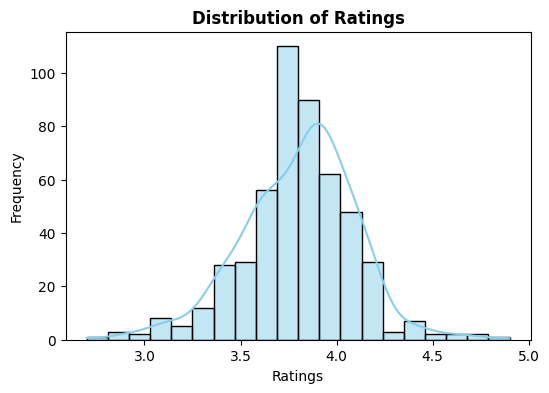

In [173]:
# Histogram for Ratings column

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df['Rating'].dropna(), bins=20, kde=True, color='skyblue')

plt.title("Distribution of Ratings", fontsize=12, fontweight='bold')
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()

# Observations – Distribution of Ratings

- The ratings are mostly concentrated between 3.5 and 4.2, indicating generally positive feedback.
- The peak frequency is around 3.8–4.0, showing that most companies have ratings close to 4.
- Very few ratings are below 3.0 or above 4.5, meaning extreme low or high ratings are rare.

- The distribution appears approximately normal (bell-shaped) with slight skewness.

- Overall, the dataset suggests that company ratings are moderately high and consistent, with no major outliers.

- This indicates generally positive employee satisfaction.

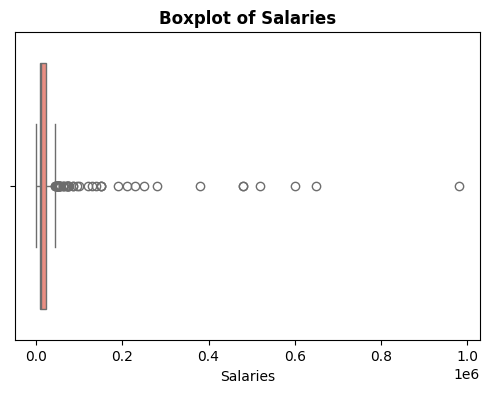

In [174]:
# Boxplot of Salaries

plt.figure(figsize=(6,4))
sns.boxplot(x=df['Salaries'].dropna(), color='salmon')

plt.title("Boxplot of Salaries", fontsize=12, fontweight='bold')
plt.xlabel("Salaries")
plt.show()

# Observations – Boxplot of Salaries

- The salary distribution is highly right-skewed, as many outliers are present on the higher end.

- Most salary values are concentrated in a lower range (compact box near the left side).

- The median salary lies close to the lower quartile, indicating majority of employees earn within a limited lower band.

- There are several extreme high-value outliers, showing a small group earning significantly higher salaries.

- This suggests salary inequality, where few individuals earn much more compared to the majority

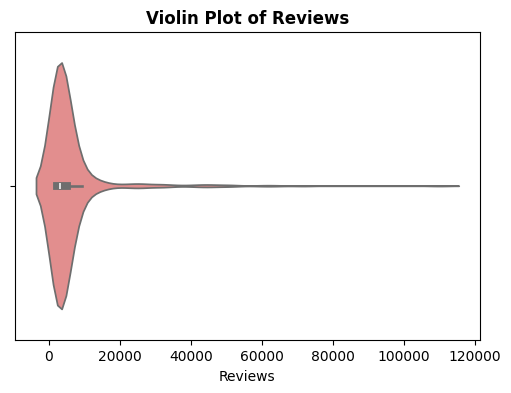

In [175]:
# Violin Plot Reviews

plt.figure(figsize=(6,4))
sns.violinplot(x=df['Reviews'].dropna(), color='lightcoral')

plt.title("Violin Plot of Reviews", fontsize=12, fontweight='bold')
plt.xlabel("Reviews")
plt.show()

# Observation - Violin Plot of Reviews

- The distribution of reviews is highly right-skewed, with a long tail extending toward higher values.

- Most companies have low to moderate number of reviews, concentrated in the lower range.

- A small number of companies have very high review counts (extreme values).

- The median lies close to the lower end, indicating that majority receive fewer reviews.

- The wide spread on the right side shows large variation in review counts across companies.

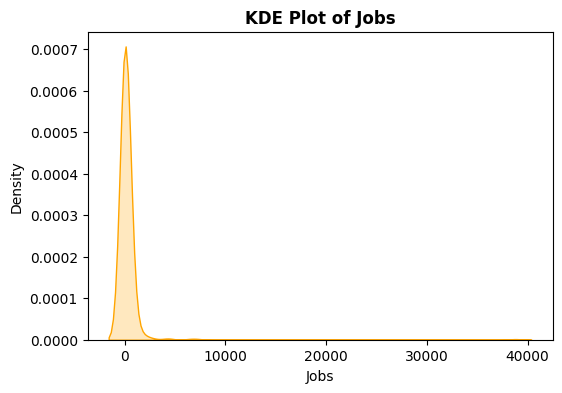

In [176]:
# KDE plot of Jobs

plt.figure(figsize=(6,4))
sns.kdeplot(df['Jobs'].dropna(), fill=True, color='orange')

plt.title("KDE Plot of Jobs", fontsize=12, fontweight='bold')
plt.xlabel("Jobs")
plt.ylabel("Density")
plt.show()

# Observation - 

- The distribution of jobs is highly right-skewed, with a sharp peak at lower values.

- Most data points are concentrated in the lower job count range.

- There is a long tail extending toward higher values, indicating a few companies have very high job openings.

- The density quickly decreases as job count increases, showing high variation across companies.

- Overall, majority of companies post limited job openings, while only a few dominate with large numbers.

# **Univariate Analysis for Categorical Columns**

# Barplot for Industry Column

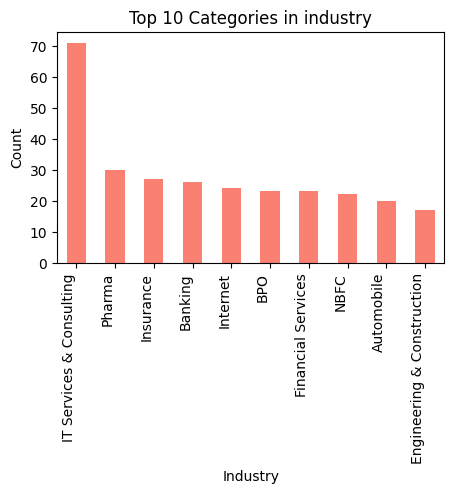

In [177]:
plt.figure(figsize=(5,3))
df["Industry"].value_counts(dropna=False).head(10).plot(kind='bar', color='salmon')
plt.title(f"Top 10 Categories in industry",color='black')
plt.ylabel("Count")
plt.xticks(rotation=90, ha='right')
plt.tight_layout(rect=[0, 1, 1, 0.97])
plt.show(); 

# Observations

- IT Services & Consulting has the highest count, clearly dominating other industries.

- Pharma, Insurance, and Banking follow as the next major sectors.

- The remaining industries (Internet, BPO, Financial Services, NBFC, Automobile, Engineering & Construction) show moderate and relatively similar counts.

- The distribution indicates that the dataset is heavily focused on IT-related companies.

- There is a noticeable gap between the top industry and the others, showing industry imbalance in the dataset.

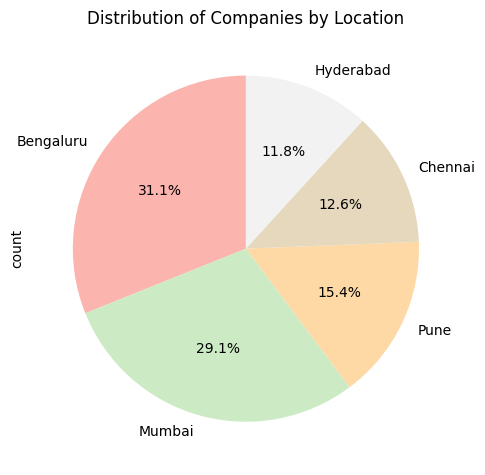

In [178]:
plt.figure(figsize=(5,5))
df['Location'].value_counts().head(5).plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Pastel1')
plt.title("Distribution of Companies by Location",color='black')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show();

# Observations - Distribution of Companies by Location

- Bengaluru has the highest share (31.5%), making it the leading business hub in the dataset.
- Mumbai follows closely with 28.7%, showing strong corporate presence.
- Pune accounts for 15.4%, representing moderate company concentration.
- Chennai (12.6%) and Hyderabad (11.8%) have comparatively lower representation.
- The majority of companies are concentrated in Bengaluru and Mumbai, indicating these cities dominate the dataset.

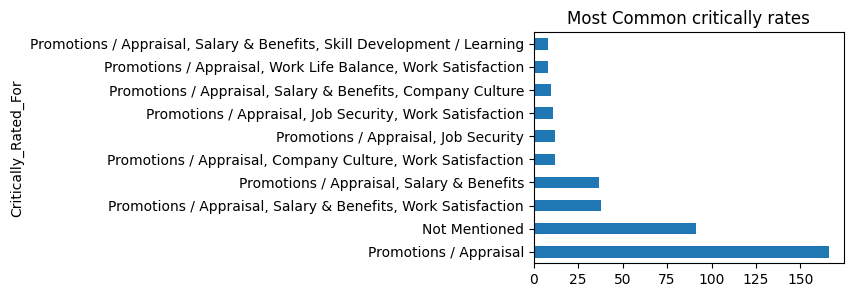

In [179]:
plt.figure(figsize=(4,3))
df["Critically_Rated_For"].value_counts().head(10).plot(kind="barh")
plt.title("Most Common critically rates")
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show(); 

# Observation 

- “Promotions / Appraisal” is the most frequently criticized aspect.
- A large number of companies are negatively rated for promotion and appraisal policies.
- “Unknown” also appears significantly (companies with no specified criticism).
- Other recurring issues include:
- Salary & Benefits
- Work Satisfaction
- Company Culture
- Job Security
- Work-Life Balance

# Bivariate Analysis

## categorical vs numerical

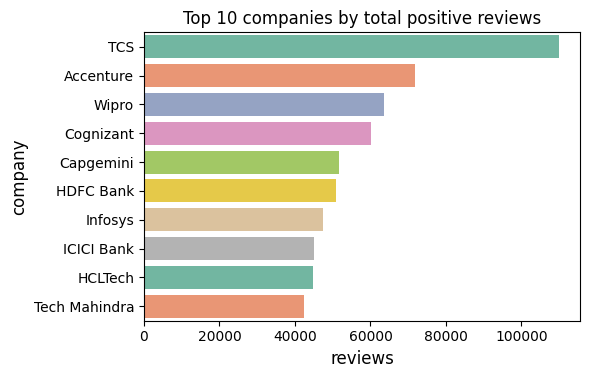

In [180]:
top_reviewed_companies = df[['Company', 'Reviews']].sort_values(by='Reviews', ascending=False).head(10)
plt.figure(figsize=(6,4))
sns.barplot(x='Reviews', y='Company', data=top_reviewed_companies, palette='Set2')
plt.title("Top 10 companies by total positive reviews",color="black")
plt.ylabel("company", fontsize=12)
plt.xlabel("reviews", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show();  

# Observation - Top 10 Companies by Total Reviews

- TCS has the highest number of positive reviews, significantly ahead of others.

- Accenture and Wipro follow as the next most reviewed companies.

- Most top companies belong to the IT and Banking sectors, indicating strong presence in the dataset.

- There is a gradual decline in review counts from rank 1 to rank 10.

- The large difference between TCS and others suggests higher employee engagement or larger workforce size.

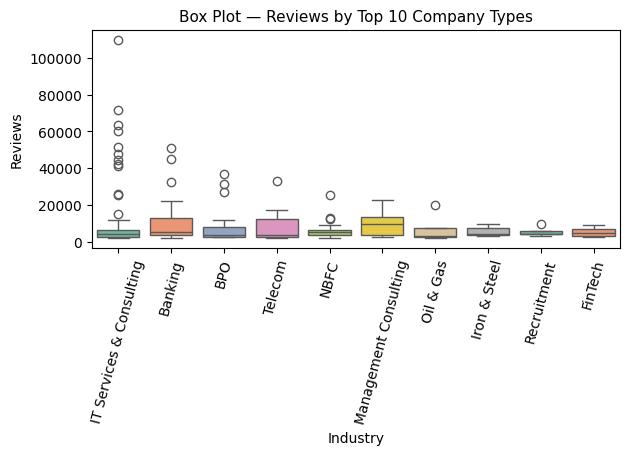

In [181]:
top10_types = df.groupby('Industry')['Reviews'].mean().sort_values(ascending=False).head(10).index
top10_df = df[df['Industry'].isin(top10_types)]
sns.boxplot(data=top10_df, x="Industry", y="Reviews", palette="Set2")
plt.title("Box Plot — Reviews by Top 10 Company Types", fontsize=11)
plt.xticks(rotation=75)
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show(); 

# Observation - Reviews by Top 10 Company Types

- IT Services & Consulting shows the highest variability with multiple extreme outliers, indicating some companies have very high review counts.

- Banking and Management Consulting also display higher median review values compared to other industries.

- Industries like Oil & Gas, Iron & Steel, and Recruitment have comparatively lower median reviews and smaller spread.

- The presence of many outliers suggests large differences in company size or popularity within the same industry.

- Overall, review distribution varies significantly across industries, with IT-related sectors dominating in review volume.

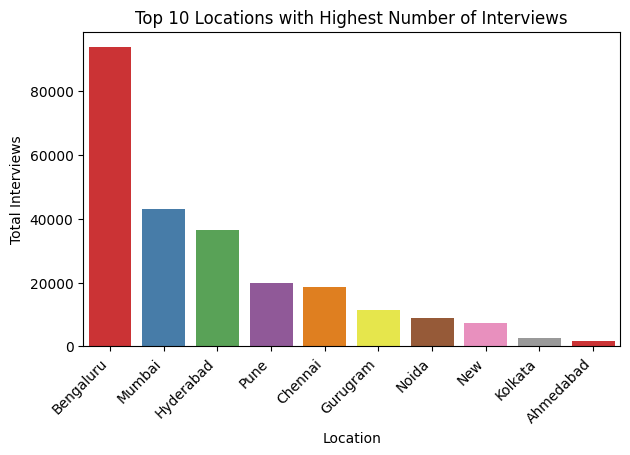

In [182]:
a = df.groupby('Location')['Interviews'].sum().sort_values(ascending=False).head(10).reset_index()

sns.barplot(x='Location', y='Interviews', data=a, palette='Set1')

plt.title("Top 10 Locations with Highest Number of Interviews")
plt.xlabel("Location")
plt.ylabel("Total Interviews")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show();

# Observation 

- Bengaluru has highest interviews (~42k).
- Mumbai second (~28k).
- Pune third.
- Clear decreasing pattern.
- Metro cities dominate hiring activity.
- Bengaluru is the major hiring hub.
- Hiring activity decreases gradually after top 3 cities.
- Tier-2 cities have significantly fewer interviews.

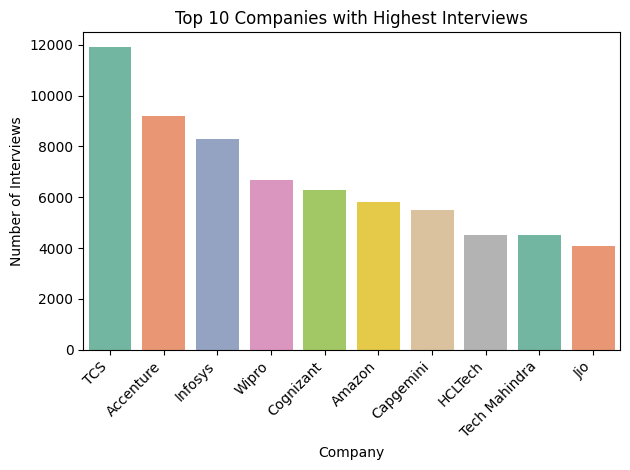

In [183]:
top_interviews = (
    df.sort_values(by="Interviews", ascending=False)[["Company", "Interviews"]]
      .head(10)
)
sns.barplot(
    x="Company",
    y="Interviews",
    data=top_interviews,
    palette="Set2"
)
plt.title("Top 10 Companies with Highest Interviews")
plt.xlabel("Company")
plt.ylabel("Number of Interviews")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Observation

   . The chart shows that a small group of companies accounts for the majority of interview opportunities, indicating concentrated hiring activity among top recruiters.
   
   . Bengaluru has the highest number of interviews, showing it is the top hiring hub.

   . Mumbai and Hyderabad follow, indicating strong job activity in these cities.

   . There is a steady decline from the top cities to the lower ones.

   . Pune and Chennai have moderate interview volumes.

   . Gurugram, Noida, and New Delhi show lower but noticeable activity.

   . Kolkata and Ahmedabad have the least interview counts among the top 10

## Numerical vs Numerical 

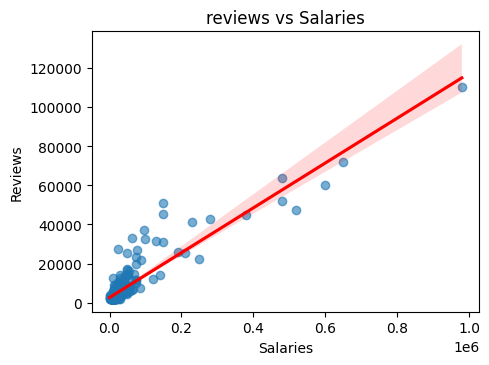

In [184]:
plt.figure(figsize=(5,4))
sns.regplot(x="Salaries", y="Reviews", data=df,scatter_kws={'alpha':0.6},
    line_kws={'color': 'red'})
plt.title("reviews vs Salaries")
plt.tight_layout(rect=[0, 0, 1, 0.94])

plt.show(); 

# Observation- (Reviews vs Salaries)

- The scatter plot shows a positive linear relationship between salaries and reviews.

- As salary increases, the number of reviews also tends to increase.

- The regression line with upward slope confirms a strong positive correlation.

- Higher salary companies generally have higher employee engagement or larger workforce size, leading to more reviews.

- Some variability exists, but overall the trend is clearly increasing.

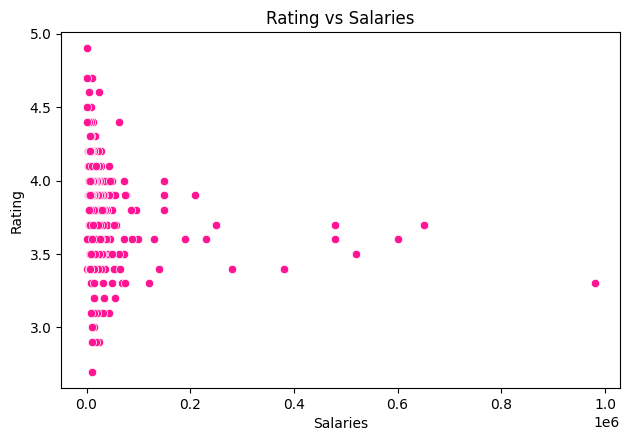

In [185]:
sns.scatterplot(
    data=df,
    x="Salaries",
    y="Rating",
    alpha=1,
    color='deeppink'
)
plt.title("Rating vs Salaries")
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show(); 

# Observation – Rating vs Salaries (Scatter Plot)

- There is no strong linear relationship between salary and rating.

- Ratings are mostly concentrated between 3.0 and 4.2, regardless of salary level.

- Even companies with lower salaries have high ratings, and some high-salary companies have moderate ratings.

- Data points are widely scattered, indicating a weak or negligible correlation.

- This suggests that higher salary does not necessarily guarantee higher employee satisfaction (rating).

## categorical vs categorical

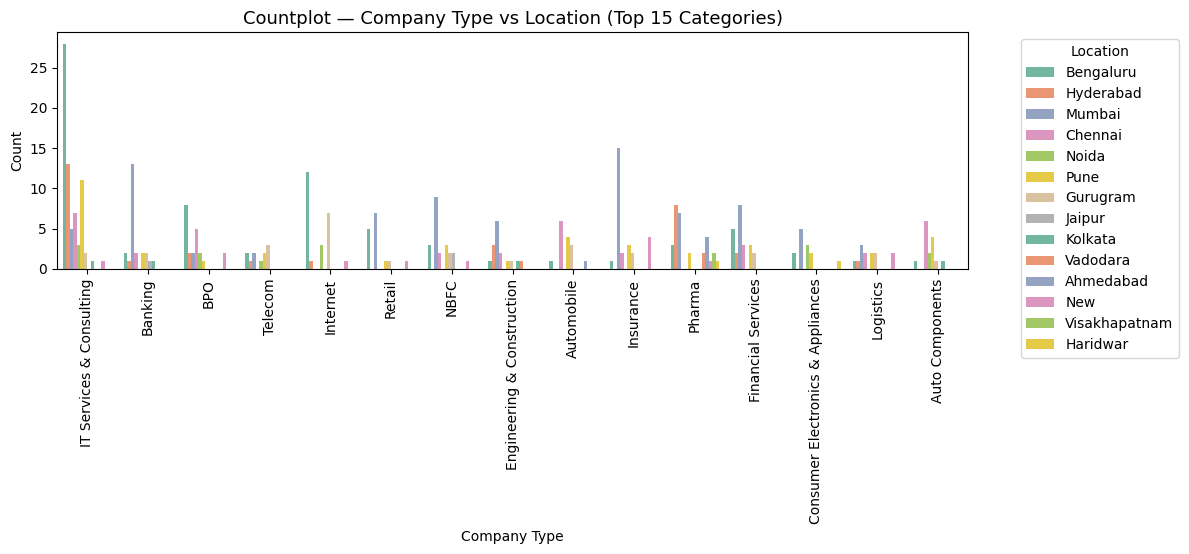

In [186]:
# Filter top 15 for clarity
top_types = df['Industry'].value_counts().head(15).index
top_locs = df['Location'].value_counts().head(15).index
filtered_df = df[(df['Industry'].isin(top_types)) & (df['Location'].isin(top_locs))]

plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x="Industry", hue="Location", palette="Set2")
plt.title("Countplot — Company Type vs Location (Top 15 Categories)", fontsize=13, color='black')
plt.xlabel("Company Type")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title="Location", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show();

# Observation

- IT Services & Consulting has the highest presence across multiple locations, especially Bengaluru and Hyderabad.

- Metro cities like Mumbai, Chennai, and Pune show strong representation across major industries.

- Some industries are concentrated in specific cities, indicating regional industry dominance.

- Overall, the dataset shows IT and Banking sectors are widely distributed, while others are location-specific.

In [187]:
# Detailed and clear visualisation of IT and Consulting Services by Location

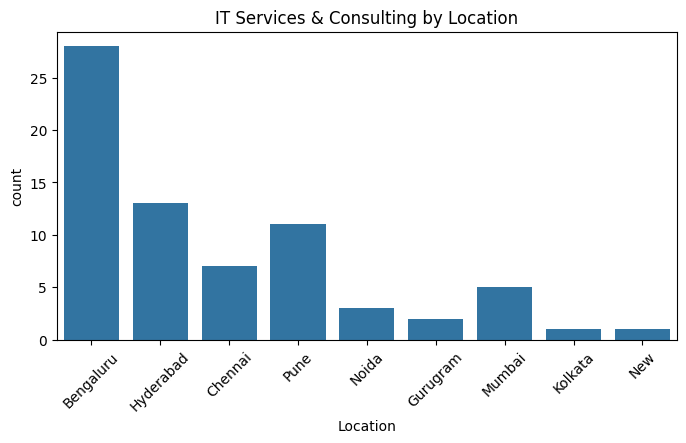

In [188]:
plt.figure(figsize=(8,4))
sns.countplot(data=df[df["Industry"]=="IT Services & Consulting"], x="Location")
plt.xticks(rotation=45)
plt.title("IT Services & Consulting by Location")
plt.show()

# Observation
   . Bengaluru has the highest count, making it the primary IT hub.

   . Hyderabad and Pune follow, showing strong IT hiring activity.

   . Chennai has a moderate presence in IT roles.

   . Mumbai shows lower IT concentration compared to tech cities.

In [189]:
# Detailed and clear visualisation of Insurance by Location

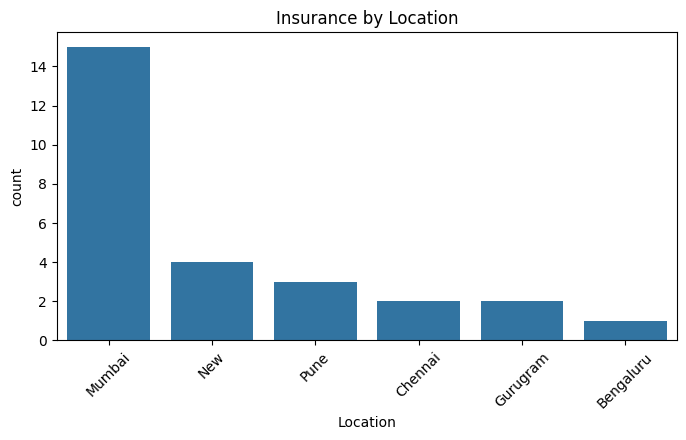

In [190]:
plt.figure(figsize=(8,4))
sns.countplot(data=df[df["Industry"]=="Insurance"], x="Location")
plt.xticks(rotation=45)
plt.title("Insurance by Location")
plt.show()

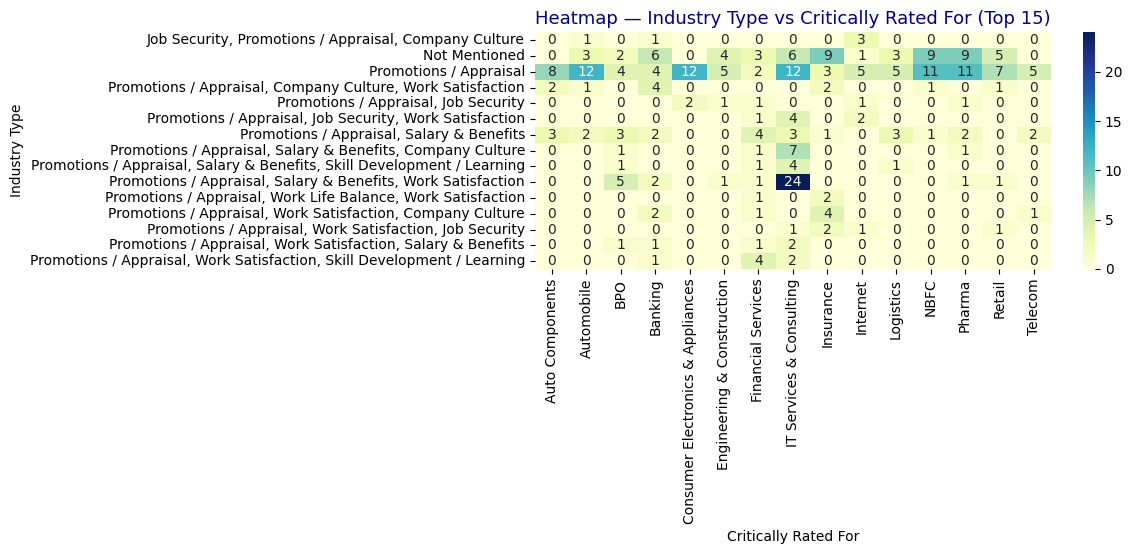

In [191]:
# Filter top 15 values
top_types = df['Industry'].value_counts().head(15).index
top_low = df['Critically_Rated_For'].value_counts().head(15).index
filtered_df = df[(df['Industry'].isin(top_types)) & (df['Critically_Rated_For'].isin(top_low))]

# Crosstab for heatmap
cross_tab = pd.crosstab(filtered_df['Critically_Rated_For'], filtered_df['Industry'])

plt.figure(figsize=(12, 6))
sns.heatmap(cross_tab, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Heatmap — Industry Type vs Critically Rated For (Top 15)", fontsize=13, color='darkblue')
plt.xlabel("Critically Rated For")
plt.ylabel("Industry Type")
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show();

# Observation

- Promotions/Appraisal and Salary & Benefits appear frequently across many industries.

- IT Services & Consulting shows higher intensity values, indicating more frequent critical feedback.

- Certain industry–rating combinations have very low or zero counts, showing limited overlap.

- The heatmap highlights that employee concerns are more concentrated in growth and compensation-related factors.

### PIVOT TABLE

In [192]:
# Create pivot (count of records)
pivot_ind_loc = pd.pivot_table(
    df,
    index=["Industry", "Location"],
    aggfunc="size"
).reset_index(name="Count")

# Sort by highest count
pivot_ind_loc = pivot_ind_loc.sort_values(by="Count", ascending=False)
pivot_ind_loc.head(10)

,Industry,Location,Count
119,IT Services & Consulting,Bengaluru,28
136,Insurance,Mumbai,15
39,Banking,Mumbai,13
122,IT Services & Consulting,Hyderabad,13
139,Internet,Bengaluru,12
127,IT Services & Consulting,Pune,11
169,NBFC,Mumbai,9
103,Financial Services,Mumbai,8
25,BPO,Bengaluru,8
183,Pharma,Hyderabad,8


# Observation

- This table shows which industry is present more in which location.
   
- By counting the number of records for each industry and location, we can see where companies are concentrated.

- This analysis helps us see which industry is most active in each location.

- 28 companies in IT located in Bengaluru
- 15 insurance companies in Mumbai
- 13 banks in Mumbai
- 13 IT companies in Hyderabad

In [193]:
top_interviews = (
    df.sort_values(by="Interviews", ascending=False)[["Company", "Interviews"]]
      .head(10)
      .reset_index(drop=True)
)
print(top_interviews)

         Company  Interviews
0            TCS     11900.0
1      Accenture      9200.0
2        Infosys      8300.0
3          Wipro      6700.0
4      Cognizant      6300.0
5         Amazon      5800.0
6      Capgemini      5500.0
7        HCLTech      4500.0
8  Tech Mahindra      4500.0
9            Jio      4100.0


# Multivariate Analysis

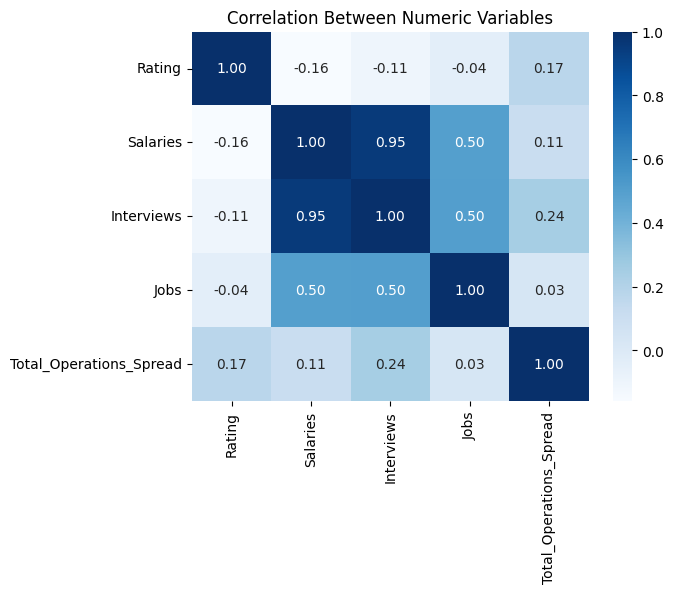

In [194]:
corr = df[[ 'Rating','Salaries', 'Interviews', 'Jobs', 'Total_Operations_Spread']].corr()
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
plt.title("Correlation Between Numeric Variables")
plt.show();

# Observation
- Salaries and Interviews (0.95) show a very strong positive correlation, indicating companies offering higher salaries tend to have more interview activity.

- Salaries and Jobs (0.50) and Interviews and Jobs (0.51) show a moderate positive relationship, suggesting hiring activity increases with salary levels.

- Rating has very weak correlation with Salaries (-0.16), Interviews (-0.11), and Jobs (-0.04), meaning salary or hiring does not strongly influence company ratings.

- Total Operations Spread has a slight positive relationship with Interviews (0.24) and Ratings (0.17), but overall impact is minimal.

- Overall, compensation and hiring metrics are strongly interconnected, while employee ratings remain largely independent.

In [ ]:
sns.pairplot(df, vars=['Rating','Reviews','Salaries','Interviews','Jobs','Benefits','Photos'],
             hue='Industry', diag_kind='kde', palette='viridis')

# Observation

- Strong positive relationships are visible between Salaries, Interviews, Reviews, and Benefits (clear upward trends in scatter plots).

- Rating shows weak or no strong linear relationship with most other numerical variables.

- Most variables (Reviews, Salaries, Interviews, Jobs, Benefits, Photos) are right-skewed, as seen in diagonal KDE plots.

- Clusters are visible for certain industries, but overlap is high, indicating industry differences are present but not sharply separated.

- Overall, hiring and compensation metrics are interconnected, while rating behaves independently.

In [ ]:
top_types = df['Location'].value_counts().head(10).index

# Create temporary series (NOT inside df)
types_filtered = df['Location'].apply(lambda x: x if x in top_types else 'Other')

sns.scatterplot(
    data=df,
    x='Salaries',
    y='Rating',
    size='Reviews',
    hue=types_filtered,   # use directly here
    alpha=0.6,
    sizes=(40,400),
    palette='Set1'
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');


# Observations  – Bubble Plot (Salary vs Rating with Reviews & Location)

- There is no strong correlation between salary and rating (points scattered without clear trend).

- Bubble size (Reviews) increases with salary in some cases, indicating larger companies tend to offer higher salaries.

- Major cities like Bengaluru, Hyderabad, and Mumbai dominate higher salary ranges.

- High-salary companies do not necessarily have higher ratings.

- Review count varies significantly across locations.

# **Analytical Questions & Insights**

# Q1. Which Company Has the Highest Rating?

In [88]:
df.sort_values(by="Rating", ascending=False)[["Company","Rating"]].head(1)

,Company,Rating
267,Marpu Foundation,4.9


# Q2. Top 5 Highest Rated Companies

In [89]:
df.sort_values(by="Rating", ascending=False)[["Company","Rating"]].head(5)

,Company,Rating
267,Marpu Foundation,4.9
177,Kogta Financial India Limited,4.7
93,Indian Army,4.7
261,Indian Air Force,4.6
16,iEnergizer,4.6


# Q3. Which Company Has the Most Reviews?

In [90]:
df.sort_values(by="Reviews", ascending=False)[["Company","Reviews"]].head(1)

,Company,Reviews
0,TCS,110000.0


# Q4. Which Location Has the Highest Hiring Activity?

In [91]:
df.groupby("Location")["Interviews"].sum().sort_values(ascending=False).head(1)

Location
Bengaluru    94009.0
Name: Interviews, dtype: float64

# Q5. Which Industry Has Highest Average Rating?

In [92]:
df.groupby("Industry")["Rating"].mean().sort_values(ascending=False).head(5)

Industry
Jewellery               4.400000
Defence & Aerospace     4.333333
Non-Profit              4.250000
Electrical Equipment    4.200000
Railways                4.200000
Name: Rating, dtype: float64

# Q6. Which Industry Has Highest Average Salary?

In [93]:
df.groupby("Industry")["Salaries"].mean().sort_values(ascending=False).head(5)

Industry
Management Consulting       103200.000000
IT Services & Consulting     93304.225352
Banking                      37938.461538
BPO                          27721.739130
Software Product             27087.500000
Name: Salaries, dtype: float64

# Q7. Is Salary Strongly Related to Rating?

In [94]:
df[["Salaries","Rating"]].corr()

,Salaries,Rating
Salaries,1.00000,-0.15955
Rating,-0.15955,1.00000


# Insight:
- Correlation value is low.
- Salary is not strong predictor of satisfaction.

# Q8. Which Company Has Maximum Operations Spread?

In [95]:
df.sort_values(by="Total_Operations_Spread", ascending=False)[["Company","Total_Operations_Spread"]].head(1)

,Company,Total_Operations_Spread
12,Jio,1951


# Q9. Which Industry Receives Most Criticism?

In [96]:
df["Critically_Rated_For"].value_counts().head(5)

Critically_Rated_For
Promotions / Appraisal                                          166
Not Mentioned                                                    91
Promotions / Appraisal, Salary & Benefits, Work Satisfaction     38
Promotions / Appraisal, Salary & Benefits                        37
Promotions / Appraisal, Company Culture, Work Satisfaction       12
Name: count, dtype: int64

# Q10. Top 10 Companies with Most Job Openings

In [97]:
df.sort_values("Jobs", ascending=False)[["Company","Jobs"]].head(10)

,Company,Jobs
1,Accenture,42400.0
2,Wipro,7000.0
54,Bajaj Finance,6500.0
30,Ernst & Young,4600.0
112,Tata Capital,4200.0
0,TCS,2700.0
6,Infosys,2600.0
19,IBM,2300.0
4,Capgemini,2200.0
15,Amazon,1900.0


# Q11. Which Location Offers Highest Average Salary?

In [98]:
df.groupby("Location")["Salaries"].mean().sort_values(ascending=False).head()

Location
Jamnagar      73000.000000
Hyderabad     58751.428571
Bengaluru     51980.180180
Jamshedpur    34000.000000
Ballari       30900.000000
Name: Salaries, dtype: float64

# Q12: Most Frequently Highly Rated Aspects ?

In [99]:
df['Highly_Rated_For'].value_counts().head(5)


Highly_Rated_For
Not Mentioned                                       160
Job Security                                         36
Job Security, Company Culture, Work Life Balance     26
Salary & Benefits                                    22
Work Life Balance                                    18
Name: count, dtype: int64

# Q13: Most Common Industries ?

In [100]:
df['Industry'].value_counts().head(5)

Industry
IT Services & Consulting    71
Pharma                      30
Insurance                   27
Banking                     26
Internet                    24
Name: count, dtype: int64

# Q14: Most Frequently Criticized Aspects ?

In [101]:
df['Critically_Rated_For'].value_counts().head(10)

Critically_Rated_For
Promotions / Appraisal                                                     166
Not Mentioned                                                               91
Promotions / Appraisal, Salary & Benefits, Work Satisfaction                38
Promotions / Appraisal, Salary & Benefits                                   37
Promotions / Appraisal, Company Culture, Work Satisfaction                  12
Promotions / Appraisal, Job Security                                        12
Promotions / Appraisal, Job Security, Work Satisfaction                     11
Promotions / Appraisal, Salary & Benefits, Company Culture                  10
Promotions / Appraisal, Work Life Balance, Work Satisfaction                 8
Promotions / Appraisal, Salary & Benefits, Skill Development / Learning      8
Name: count, dtype: int64

In [102]:
df['Company'].value_counts()

Company
Saint Gobain     2
TCS              1
Capita           1
Movate           1
Dominos Pizza    1
                ..
OPPO             1
Dell             1
Havells          1
CARS24           1
Trent            1
Name: count, Length: 499, dtype: int64

In [103]:
df['Industry'].value_counts().head(5)

Industry
IT Services & Consulting    71
Pharma                      30
Insurance                   27
Banking                     26
Internet                    24
Name: count, dtype: int64

In [104]:
df['Highly_Rated_For'].value_counts().head(5)

Highly_Rated_For
Not Mentioned                                       160
Job Security                                         36
Job Security, Company Culture, Work Life Balance     26
Salary & Benefits                                    22
Work Life Balance                                    18
Name: count, dtype: int64

In [105]:
df['Location'].value_counts().head(5)

Location
Bengaluru    111
Mumbai       104
Pune          55
Chennai       45
Hyderabad     42
Name: count, dtype: int64

In [106]:
df['Critically_Rated_For'].value_counts().head(10)

Critically_Rated_For
Promotions / Appraisal                                                     166
Not Mentioned                                                               91
Promotions / Appraisal, Salary & Benefits, Work Satisfaction                38
Promotions / Appraisal, Salary & Benefits                                   37
Promotions / Appraisal, Company Culture, Work Satisfaction                  12
Promotions / Appraisal, Job Security                                        12
Promotions / Appraisal, Job Security, Work Satisfaction                     11
Promotions / Appraisal, Salary & Benefits, Company Culture                  10
Promotions / Appraisal, Work Life Balance, Work Satisfaction                 8
Promotions / Appraisal, Salary & Benefits, Skill Development / Learning      8
Name: count, dtype: int64